<a href="https://colab.research.google.com/github/hahaSam351/Study/blob/main/02_2_Titanic_Sam(overfitting).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic - Machine Learning from Disaster
- https://www.kaggle.com/c/titanic
- https://kaggle-kr.tistory.com/17?category=868316
- 윤재성 강사님 강의
- https://www.kaggle.com/ash316/eda-to-prediction-dietanic
- https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
- 파이썬 머신러닝 완벽 가이드

# 1) Load and check data

## 1-1) Library

In [ ]:
# 1.기본
# data handling
import numpy as np
import pandas as pd
# pd.set_option('display.max_columns', 100)

# visualization
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'   # 윈도우 폰트
# plt.rcParams['font.family'] = 'AppleGothic'   # 애플 폰트
plt.rcParams['font.size'] = 14   # 폰트 크기
plt.rcParams['figure.figsize'] = 8, 8   # 그래프 크기
plt.rcParams['axes.unicode_minus'] = False   # 음수에서 폰트 깨지는거 방지
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep', font_scale=1.5)

import warnings
warnings.filterwarnings('ignore')


# 2. 데이터 가져오기
from google.colab import drive
drive.mount('/content/drive')


# 3. 데이터 전처리
# 결정나무, 랜덤 포레스트, 나이브 베이즈 분류 => 원본 데이터 그대로 유지
from sklearn.preprocessing import StandardScaler # SVM(RBF), 로지스틱회귀, 선형회귀, 인공신경망의 경우 표준화(standardization)
from sklearn.preprocessing import MinMaxScaler # 군집 분석의 경우 정규화(normalization)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
import missingno as msno
from imblearn.over_sampling import SMOTE

# 4. 훈련/검증용 데이터 분리
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold

# 5. 분류 모델 구축
# clf (Classifier)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# Voting
from sklearn.ensemble import VotingClassifier
# Bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
# Boosting
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
# Stacking
from sklearn.ensemble import StackingClassifier


# 6. 모델 검정
from sklearn import metrics   # accuracy measure
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, make_scorer, classification_report, mean_absolute_error
from sklearn.model_selection import cross_val_score # 검증 지표를 하나만 사용할 경우
from sklearn.model_selection import cross_validate # 검증 지표를 다수를 설정할 경우
from sklearn.model_selection import cross_val_predict


# 7. 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve, validation_curve

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1-2) Load and Data Check 

In [ ]:
train = pd.read_csv(r'/content/drive/MyDrive/DataAnalysis/data/titanic_train.csv')
test = pd.read_csv(r'/content/drive/MyDrive/DataAnalysis/data/titanic_test.csv')
IDtest = test['PassengerId']

In [ ]:
# Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [ ]:
print('train.shape :', train.shape)
print('test.shape :', test.shape)
print('dataset.shape :', dataset.shape)

train.shape : (891, 12)
test.shape : (418, 11)
dataset.shape : (1309, 12)


In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


- info

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [ ]:
dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [ ]:
dataset.describe(include=['object'])

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


In [ ]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

# 2) EDA

## 2-1) Target

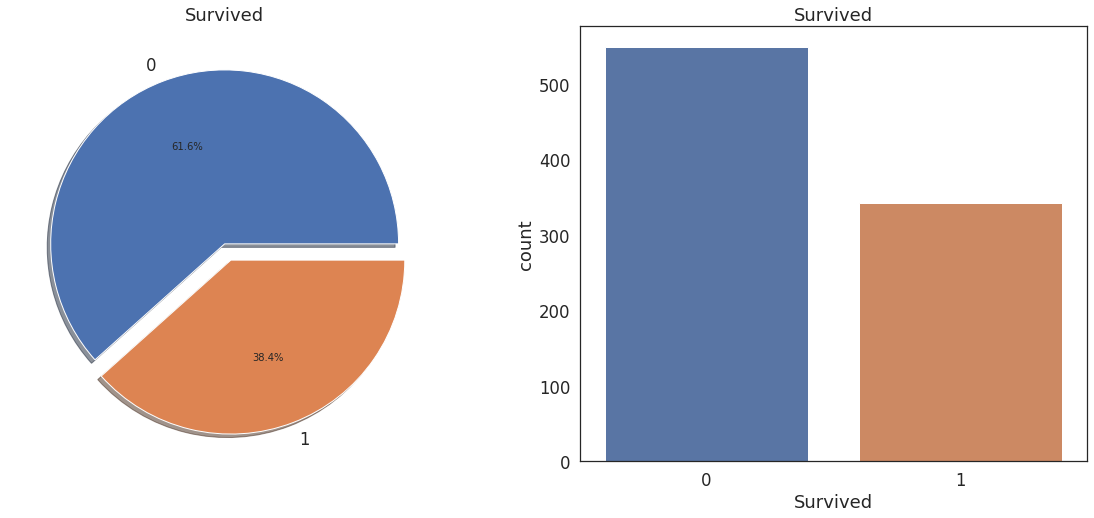

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(20,8))
train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')

sns.countplot('Survived', data=train, ax=ax[1])
ax[1].set_title('Survived')
plt.show()

## 2-2) Featrues

In [ ]:
dataset.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Sex

In [ ]:
train.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

In [ ]:
train[['Sex', 'Survived']].groupby(['Sex']).mean()

,Survived
Sex,
female,0.742038
male,0.188908


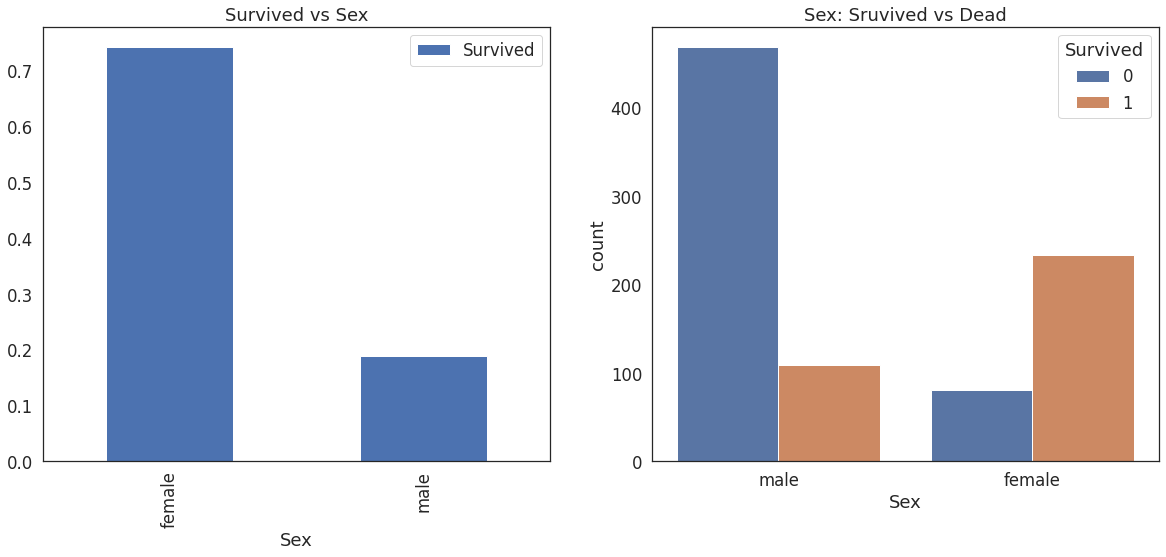

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(20,8))
train[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')

sns.countplot('Sex', hue='Survived', data=train, ax=ax[1])
ax[1].set_title('Sex: Sruvived vs Dead')
plt.show()

### Pclass

In [ ]:
pd.crosstab(train.Pclass, train.Survived, margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


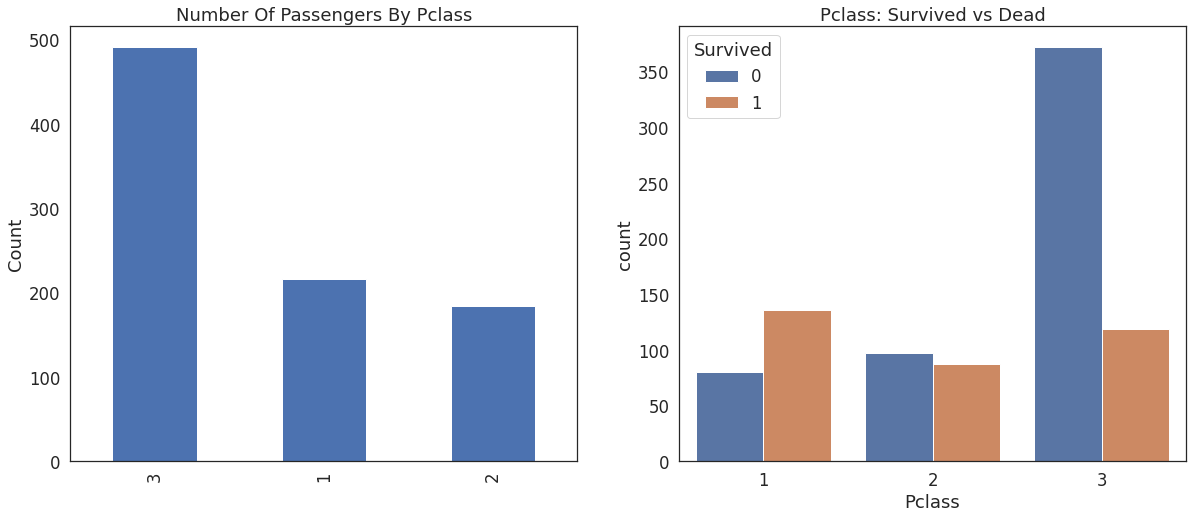

In [ ]:
f, ax = plt.subplots(1,2, figsize=(20,8))
train['Pclass'].value_counts().plot.bar(ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')

sns.countplot('Pclass', hue='Survived', data=train, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead')
plt.show()

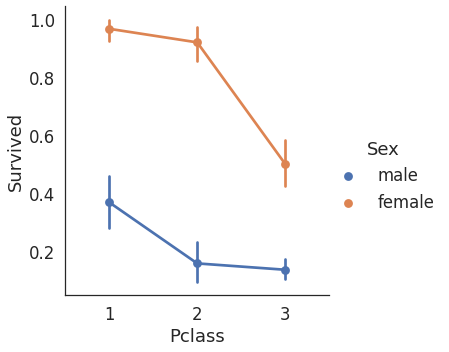

In [ ]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=train)
plt.show()

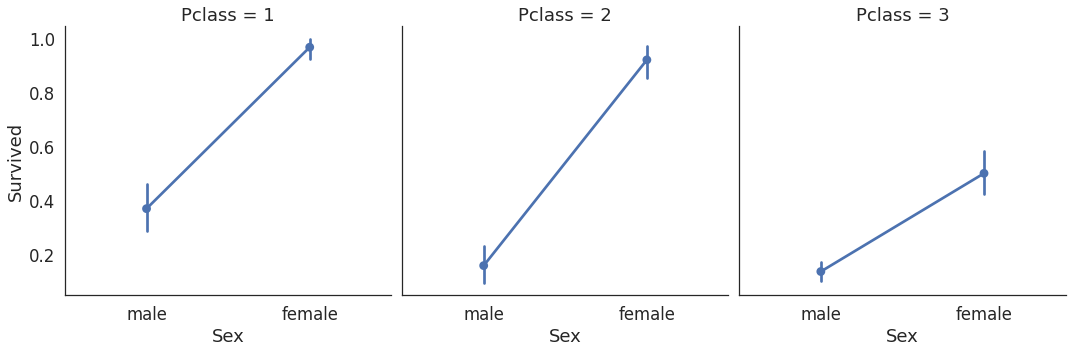

In [ ]:
sns.factorplot(x='Sex', y='Survived', col='Pclass', data=train, satureation=.5, aspect=1);

### Age (NaN)

In [ ]:
print('Oldest Passenger was of : ', dataset['Age'].max())
print('youngest Passenger was of : ', dataset['Age'].min())
print('Average Passenger was of : ', dataset['Age'].mean())

Oldest Passenger was of :  80.0
youngest Passenger was of :  0.17
Average Passenger was of :  29.881137667304014


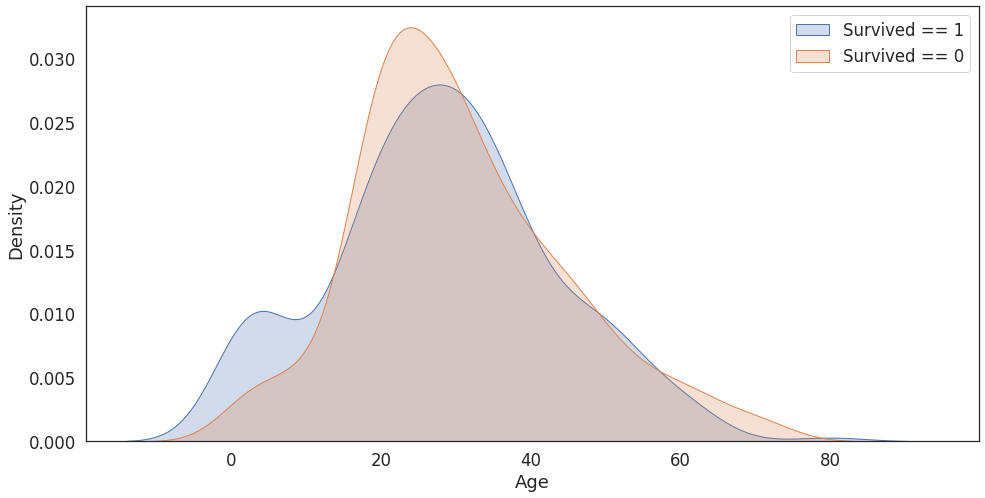

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.kdeplot(train[train['Survived'] == 1]['Age'], ax=ax, shade=True)
sns.kdeplot(train[train['Survived'] == 0]['Age'], ax=ax, shade=True)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.show()

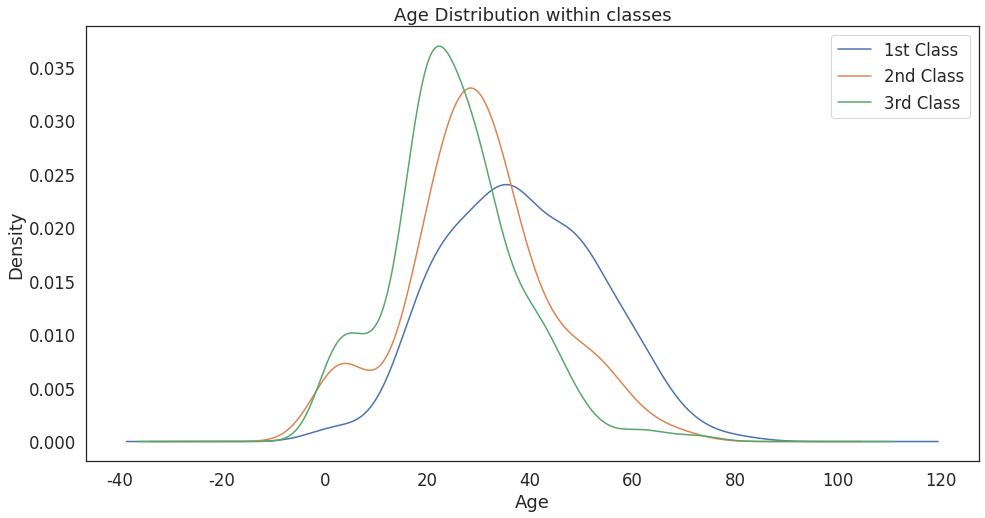

In [ ]:
# Age distribution withing classes
plt.figure(figsize=(16, 8))
train['Age'][train['Pclass'] == 1].plot(kind='kde')
train['Age'][train['Pclass'] == 2].plot(kind='kde')
train['Age'][train['Pclass'] == 3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])
plt.show()

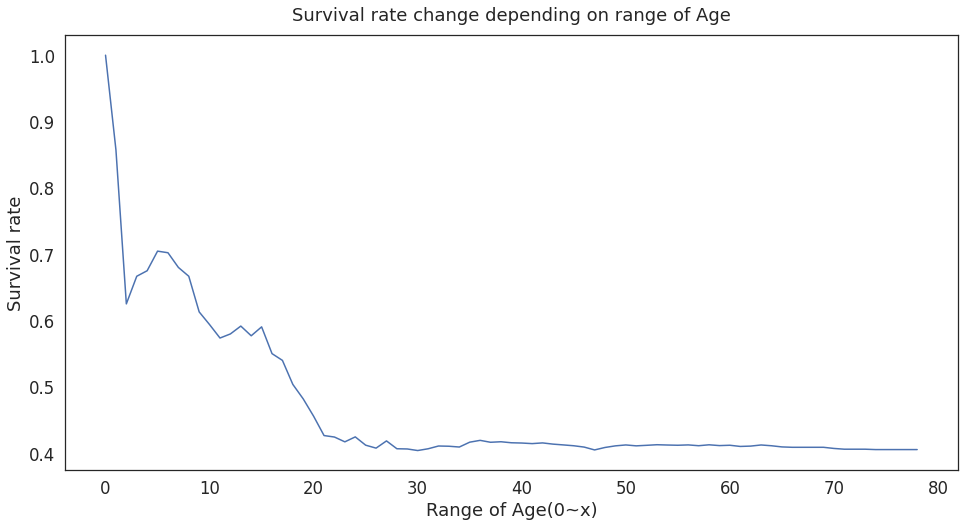

In [ ]:
cummulate_survival_ratio = []
for i in range(1, 80):
    cummulate_survival_ratio.append(train[train['Age'] < i]['Survived'].sum() / len(train[train['Age'] < i]['Survived']))
    
plt.figure(figsize=(16, 8))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~x)')
plt.show()

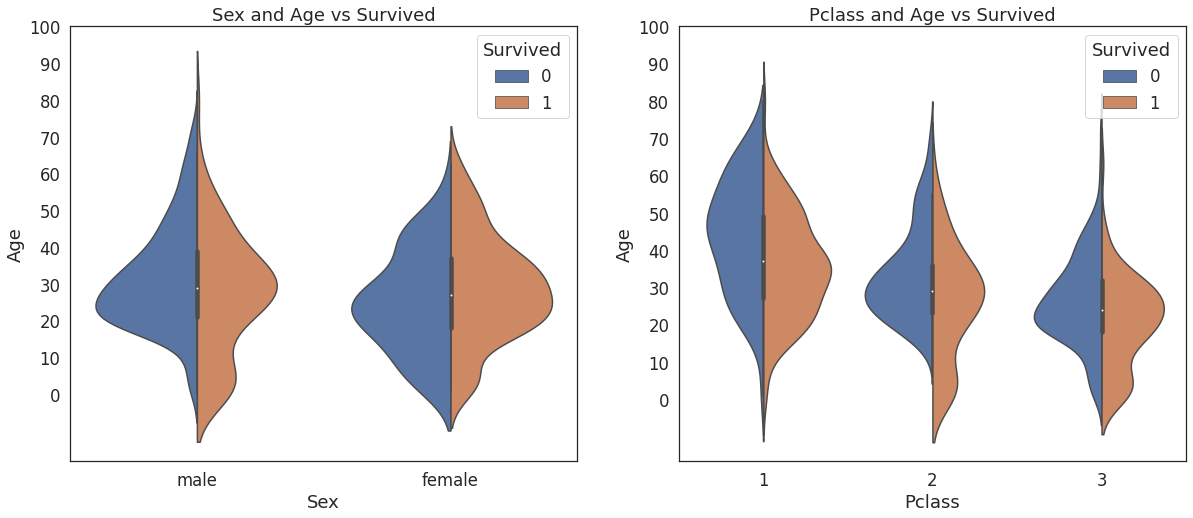

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(20,8))
sns.violinplot('Sex', 'Age', hue='Survived', data=train, split=True, ax=ax[0])
ax[0].set_title('Sex and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))

sns.violinplot('Pclass', 'Age', hue='Survived', data=train, split=True, ax=ax[1])
ax[1].set_title('Pclass and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))

plt.show()

- filling NaN values

In [ ]:
dataset['Initial'] = 0
for i in dataset :
  dataset['Initial'] = dataset.Name.str.extract('([A-Za-z]+)\.')

In [ ]:
pd.crosstab(dataset.Initial, dataset.Sex).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [ ]:
dataset['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mr'],
                        inplace=True)

In [ ]:
dataset.groupby('Initial')['Age'].mean()

Initial
Master     5.482642
Miss      21.834533
Mr        32.556397
Mrs       37.034884
Other     44.923077
Name: Age, dtype: float64

In [ ]:
dataset.loc[(dataset.Age.isnull())&(dataset.Initial=='Master'),'Age']=5
dataset.loc[(dataset.Age.isnull())&(dataset.Initial=='Miss'),'Age']=22
dataset.loc[(dataset.Age.isnull())&(dataset.Initial=='Mr'),'Age']=33
dataset.loc[(dataset.Age.isnull())&(dataset.Initial=='Mrs'),'Age']=37
dataset.loc[(dataset.Age.isnull())&(dataset.Initial=='Other'),'Age']=45

In [ ]:
dataset.Age.isnull().any()

False

### Embarked (NaN)

In [ ]:
pd.crosstab([train.Embarked, train.Pclass], [train.Sex, train.Survived], margins=True).style.background_gradient(cmap='summer_r')

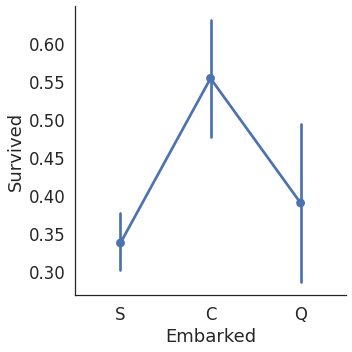

In [ ]:
sns.factorplot('Embarked','Survived',data=train)
plt.show()

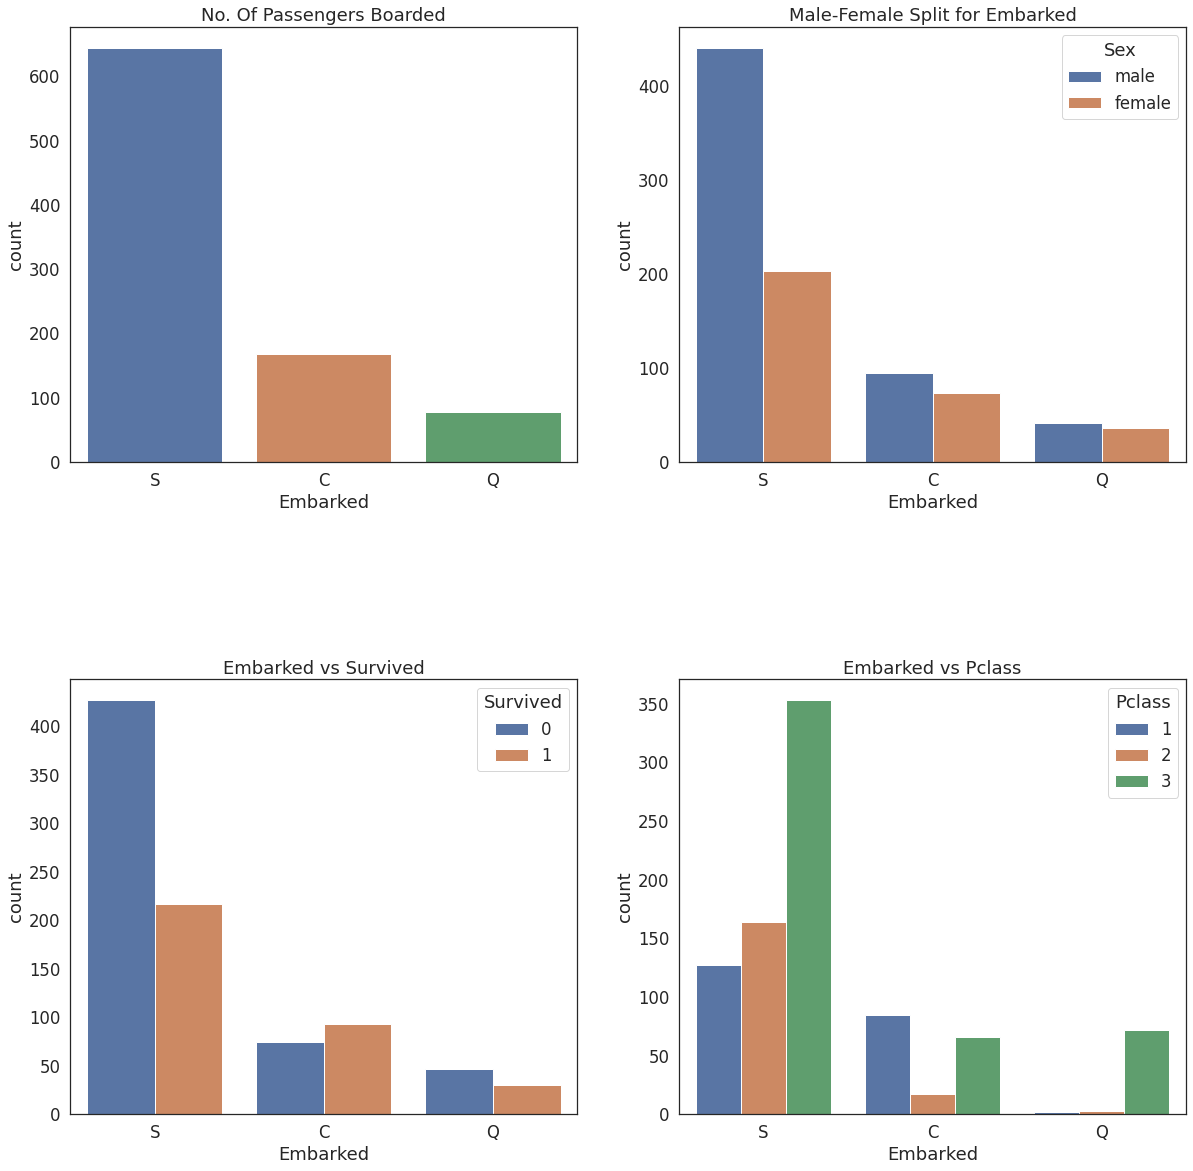

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(20,20))

sns.countplot('Embarked', data=train, ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')

sns.countplot('Embarked', hue='Sex', data=train, ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')

sns.countplot('Embarked', hue='Survived', data=train, ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')

sns.countplot('Embarked', hue='Pclass', data=train, ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

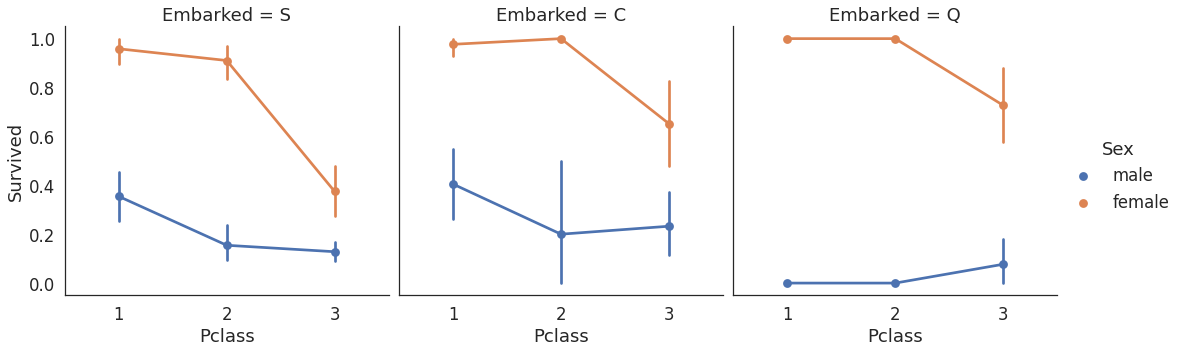

In [ ]:
sns.factorplot('Pclass', 'Survived', hue='Sex', col='Embarked', data=train)
plt.show()

- fiiling NaN values

In [ ]:
dataset['Embarked'].fillna('S', inplace=True)

In [ ]:
dataset.Embarked.isnull().any()

False

### SibSip

In [ ]:
pd.crosstab([train.SibSp], train.Survived).style.background_gradient(cmap='summer_r')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


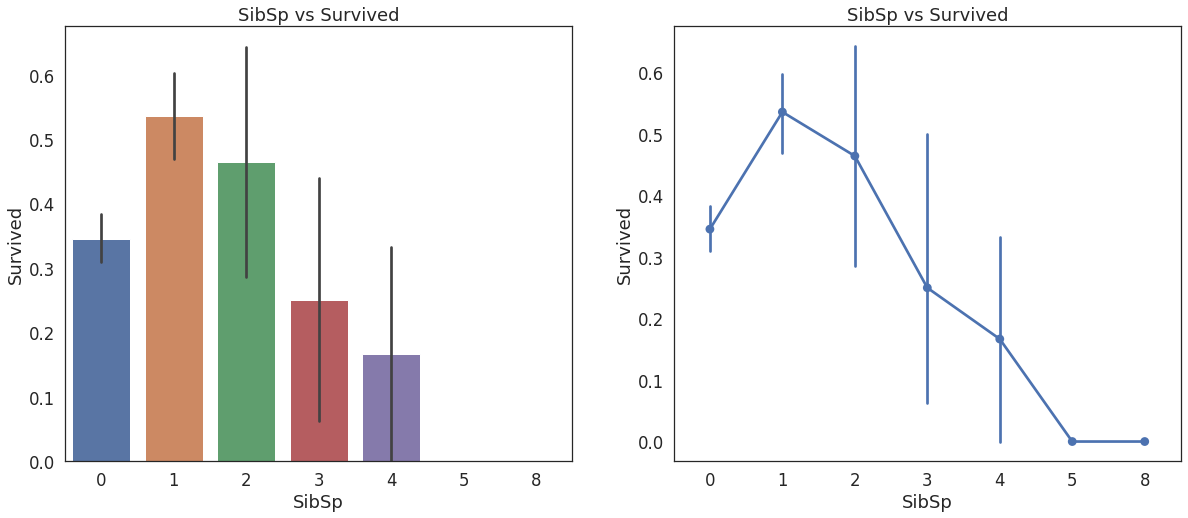

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(20,8))

sns.barplot('SibSp', 'Survived', data=train, ax=ax[0])
ax[0].set_title('SibSp vs Survived')

sns.pointplot('SibSp', 'Survived', data=train, ax=ax[1])
ax[1].set_title('SibSp vs Survived')

plt.show()

In [ ]:
pd.crosstab(train.SibSp, train.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


### Parch

In [ ]:
pd.crosstab(train.Parch, train.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


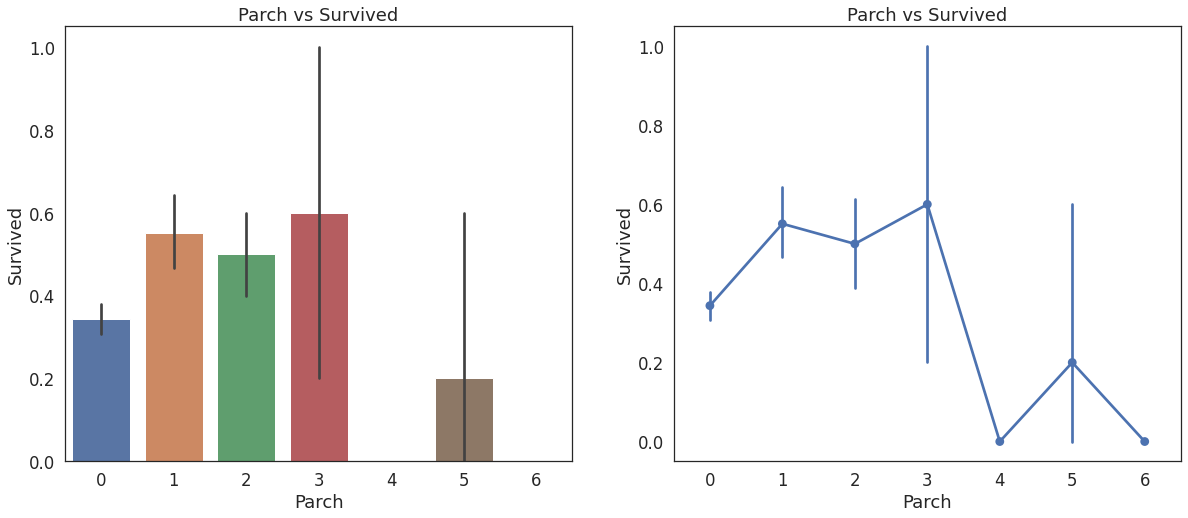

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(20,8))

sns.barplot('Parch', 'Survived', data=train, ax=ax[0])
ax[0].set_title('Parch vs Survived')

sns.pointplot('Parch', 'Survived', data=train, ax=ax[1])
ax[1].set_title('Parch vs Survived')

plt.show()

### Fare (NaN)

- filling NaN values

In [ ]:
dataset['Fare'].isnull().sum()

1

In [ ]:
# Fill Fare missing values with the median value
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

In [ ]:
dataset.Fare.isnull().any()

False

- EDA

In [ ]:
print('Highest Fare', dataset['Fare'].max())
print('Lowest Fare', dataset['Fare'].min())
print('Average Fare', dataset['Fare'].mean())

Highest Fare 512.3292
Lowest Fare 0.0
Average Fare 33.28108563789156


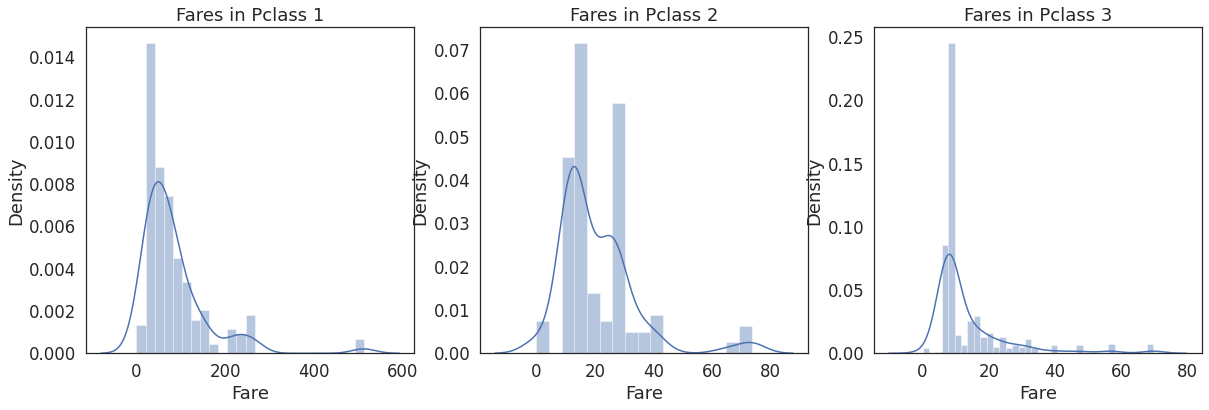

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(20,6))

sns.distplot(train[train['Pclass']==1].Fare, ax=ax[0])
ax[0].set_title('Fares in Pclass 1')

sns.distplot(train[train['Pclass']==2].Fare, ax=ax[1])
ax[1].set_title('Fares in Pclass 2')

sns.distplot(train[train['Pclass']==3].Fare, ax=ax[2])
ax[2].set_title('Fares in Pclass 3')

plt.show()

- skew

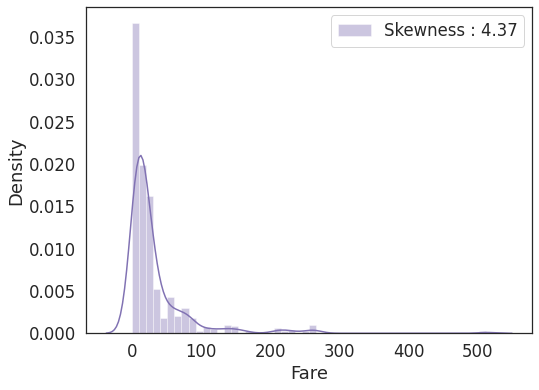

In [ ]:
plt.figure(figsize=(8, 6))
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

In [ ]:
# Apply log to Fare to reduct skewness distribution
dataset['Fare'] = dataset['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

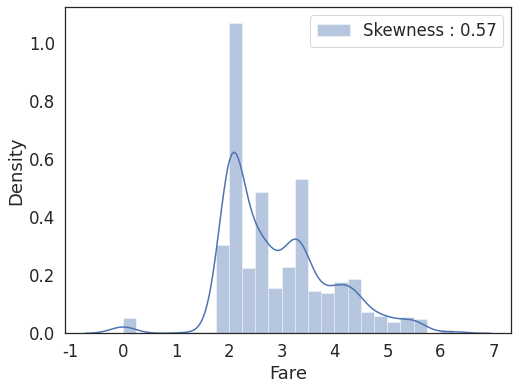

In [ ]:
plt.figure(figsize=(8, 6))
g = sns.distplot(dataset['Fare'], color='b', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

## 2-3) Correlation

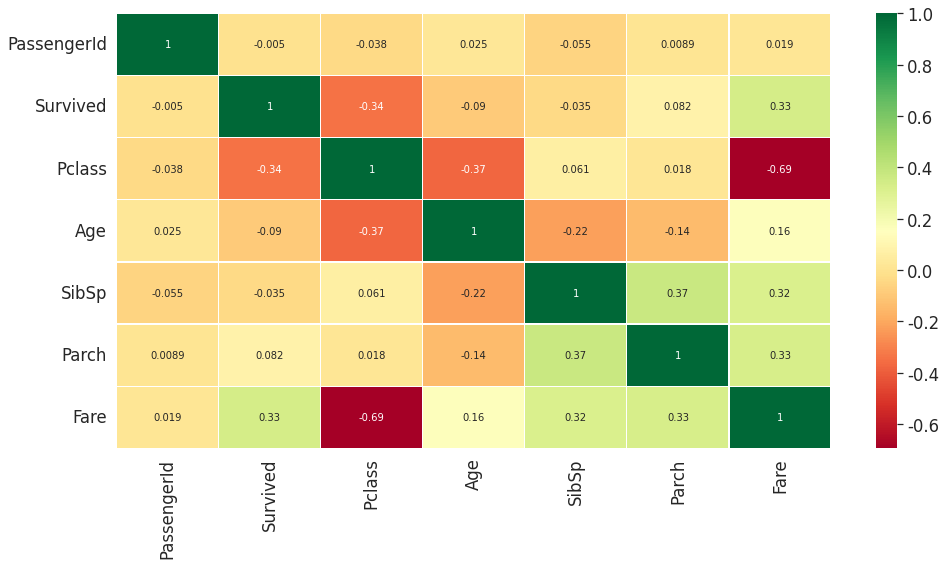

In [ ]:
sns.heatmap(dataset.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)   # data.corr()
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

# 3) Feature Engineering

## 3-1) Adding any features

### Age_band
- continuous 를 categorical 로 바꾸면 자칫 information loss 가 생길 수도 있음

In [ ]:
# the maximum age of a passenger was 80. So lets divide the range from 0-80 into 5 bins. So 80/5=16. So bins of size 16.
dataset['Age_band'] = 0
dataset.loc[dataset['Age']<=16, 'Age_band'] = 0
dataset.loc[(dataset['Age']>16) & (dataset['Age']<=32), 'Age_band'] = 1
dataset.loc[(dataset['Age']>32) & (dataset['Age']<=48), 'Age_band'] = 2
dataset.loc[(dataset['Age']>48) & (dataset['Age']<=64), 'Age_band'] = 3
dataset.loc[dataset['Age']>64, 'Age_band'] = 4
dataset.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,Mr,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,Mrs,2


In [ ]:
dataset['Age_band'].value_counts().to_frame().style.background_gradient(cmap='summer')

,Age_band
1,575
2,473
0,142
3,106
4,13


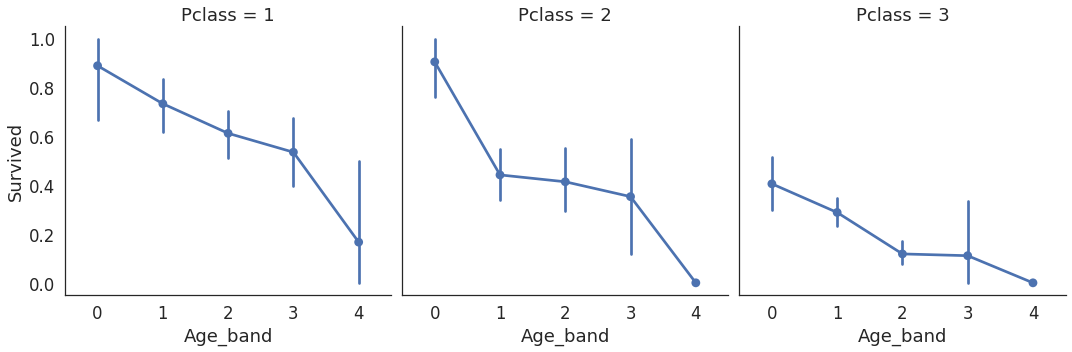

In [ ]:
sns.factorplot('Age_band', 'Survived', data=dataset, col='Pclass')
plt.show()

### Family Size

In [ ]:
# Create a family size descriptor from SibSp and Parch
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

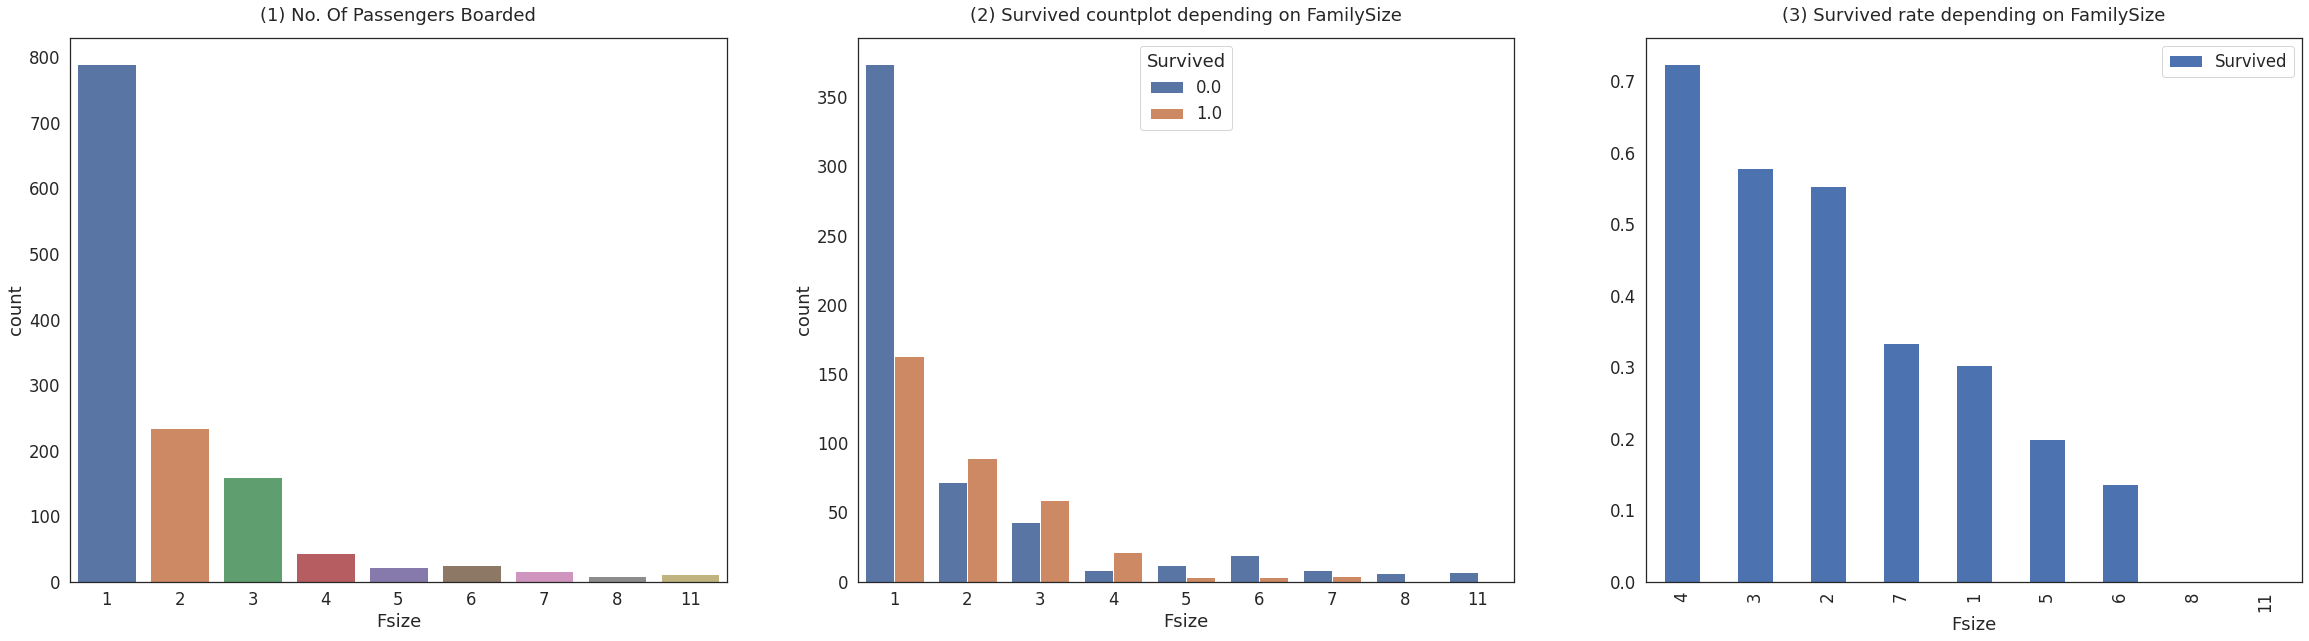

In [ ]:
f,ax=plt.subplots(1, 3, figsize=(40,10))
sns.countplot('Fsize', data=dataset, ax=ax[0])
ax[0].set_title('(1) No. Of Passengers Boarded', y=1.02)

sns.countplot('Fsize', hue='Survived', data=dataset, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize',  y=1.02)

dataset[['Fsize', 'Survived']].groupby(['Fsize'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize',  y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### Fare_Range

In [ ]:
dataset['Fare_Range']=pd.qcut(dataset['Fare'], 4)
dataset.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 2.066]",0.197309
"(2.066, 2.671]",0.303571
"(2.671, 3.443]",0.441048
"(3.443, 6.239]",0.600000


In [ ]:
dataset['Fare_cat']=0
dataset.loc[dataset['Fare']<=2.06, 'Fare_cat'] = 0
dataset.loc[(dataset['Fare']>2.06) & (dataset['Fare']<2.67), 'Fare_cat'] = 1
dataset.loc[(dataset['Fare']>2.67) & (dataset['Fare']<3.44), 'Fare_cat'] = 2
dataset.loc[dataset['Fare']>3.44, 'Fare_cat'] = 3

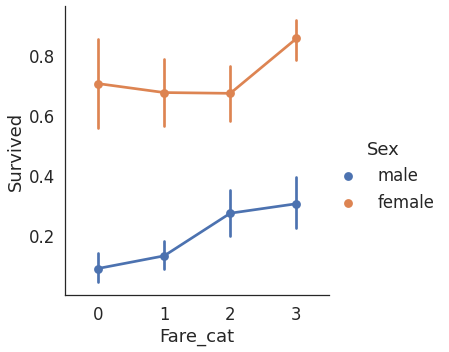

In [ ]:
sns.factorplot('Fare_cat','Survived',data=dataset,hue='Sex')
plt.show()

## 3-2) Dropping UnNeeded features

In [ ]:
dataset.drop(['PassengerId','Name','Age','SibSp','Parch','Ticket','Fare','Cabin','Fare_Range'], axis=1, inplace=True)

In [ ]:
dataset.head()

,Survived,Pclass,Sex,Embarked,Initial,Age_band,Fsize,Fare_cat
0,0.0,3,male,S,Mr,1,2,0
1,1.0,1,female,C,Mrs,2,2,3
2,1.0,3,female,S,Miss,1,1,1
3,1.0,1,female,S,Mrs,2,2,3
4,0.0,3,male,S,Mr,2,1,1


## 3-3) Encoding (categorical)

In [ ]:
dataset = pd.get_dummies(dataset, columns=['Pclass', 'Sex', 'Embarked', 'Initial'])

In [ ]:
dataset.head()

,Survived,Age_band,Fsize,Fare_cat,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Initial_Master,Initial_Miss,Initial_Mr,Initial_Mrs,Initial_Other
0,0.0,1,2,0,0,0,1,0,1,0,0,1,0,0,1,0,0
1,1.0,2,2,3,1,0,0,1,0,1,0,0,0,0,0,1,0
2,1.0,1,1,1,0,0,1,1,0,0,0,1,0,1,0,0,0
3,1.0,2,2,3,1,0,0,1,0,0,0,1,0,0,0,1,0
4,0.0,2,1,1,0,0,1,0,1,0,0,1,0,0,1,0,0


## 3-4) Other Engineering

### Mean, Max, Min, Diff

In [ ]:
dataset.groupby('Age_band')['Survived'].count()

Age_band
0    104
1    382
2    325
3     69
4     11
Name: Survived, dtype: int64

In [ ]:
dataset.groupby('Age_band')['Survived'].mean()

Age_band
0    0.548077
1    0.392670
2    0.320000
3    0.434783
4    0.090909
Name: Survived, dtype: float64

In [ ]:
dataset.groupby('Age_band')['Survived'].transform('mean')

0       0.392670
1       0.320000
2       0.392670
3       0.320000
4       0.320000
          ...   
1304    0.320000
1305    0.320000
1306    0.320000
1307    0.320000
1308    0.548077
Name: Survived, Length: 1309, dtype: float64

In [ ]:
temp = dataset.copy()

for key in dataset.columns:
    temp[key] = temp.groupby(key)['Survived'].transform('mean')

temp

,Survived,Age_band,Fsize,Fare_cat,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Initial_Master,Initial_Miss,Initial_Mr,Initial_Mrs,Initial_Other
0,0.0,0.392670,0.552795,0.216867,0.305185,0.360679,0.242363,0.188908,0.188908,0.344398,0.383292,0.339009,0.374853,0.299291,0.162571,0.315445,0.386621
1,1.0,0.320000,0.552795,0.581081,0.629630,0.360679,0.557500,0.742038,0.742038,0.553571,0.383292,0.502041,0.374853,0.299291,0.707182,0.795276,0.386621
2,1.0,0.392670,0.303538,0.273723,0.305185,0.360679,0.242363,0.742038,0.742038,0.344398,0.383292,0.339009,0.374853,0.704301,0.707182,0.315445,0.386621
3,1.0,0.320000,0.552795,0.581081,0.629630,0.360679,0.557500,0.742038,0.742038,0.344398,0.383292,0.339009,0.374853,0.299291,0.707182,0.795276,0.386621
4,0.0,0.320000,0.303538,0.273723,0.305185,0.360679,0.242363,0.188908,0.188908,0.344398,0.383292,0.339009,0.374853,0.299291,0.162571,0.315445,0.386621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,0.320000,0.303538,0.273723,0.305185,0.360679,0.242363,0.188908,0.188908,0.344398,0.383292,0.339009,0.374853,0.299291,0.162571,0.315445,0.386621
1305,NaN,0.320000,0.303538,0.581081,0.629630,0.360679,0.557500,0.742038,0.742038,0.553571,0.383292,0.502041,0.374853,0.299291,0.162571,0.315445,0.386621
1306,NaN,0.320000,0.303538,0.216867,0.305185,0.360679,0.242363,0.188908,0.188908,0.344398,0.383292,0.339009,0.374853,0.299291,0.162571,0.315445,0.386621
1307,NaN,0.320000,0.303538,0.273723,0.305185,0.360679,0.242363,0.188908,0.188908,0.344398,0.383292,0.339009,0.374853,0.299291,0.162571,0.315445,0.386621


In [ ]:
# 생존률을 기반으로 통계값을 구한다.
temp['Mean'] = 0
temp['Max'] = 0
temp['Min'] = 0
temp['Diff'] = 0

In [ ]:
temp['Mean'] = temp.mean(axis=1)
temp['Max'] = temp.max(axis=1)
temp['Min'] = temp.min(axis=1)
temp['Diff'] = temp['Max'] - temp['Min']

In [ ]:
# 구한 통계값을 원래의 데이터에 넣어준다
dataset['Mean'] = temp['Mean']
dataset['Max'] = temp['Max']
dataset['Min'] = temp['Min']
dataset['Diff'] = temp['Diff']

dataset

,Survived,Age_band,Fsize,Fare_cat,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,...,Embarked_S,Initial_Master,Initial_Miss,Initial_Mr,Initial_Mrs,Initial_Other,Mean,Max,Min,Diff
0,0.0,1,2,0,0,0,1,0,1,0,...,1,0,0,1,0,0,0.240660,0.552795,0.0,0.552795
1,1.0,2,2,3,1,0,0,1,0,1,...,0,0,0,0,1,0,0.451804,1.000000,0.0,1.000000
2,1.0,1,1,1,0,0,1,1,0,0,...,1,0,1,0,0,0,0.377016,1.000000,0.0,1.000000
3,1.0,2,2,3,1,0,0,1,0,0,...,1,0,0,0,1,0,0.434080,1.000000,0.0,1.000000
4,0.0,2,1,1,0,0,1,0,1,0,...,1,0,0,1,0,0,0.228037,0.386621,0.0,0.386621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,2,1,1,0,0,1,0,1,0,...,1,0,0,1,0,0,0.239439,0.386621,0.0,0.386621
1305,NaN,2,1,3,1,0,0,1,0,1,...,0,0,0,1,0,0,0.360709,0.742038,0.0,0.742038
1306,NaN,2,1,0,0,0,1,0,1,0,...,1,0,0,1,0,0,0.236596,0.386621,0.0,0.386621
1307,NaN,2,1,1,0,0,1,0,1,0,...,1,0,0,1,0,0,0.239439,0.386621,0.0,0.386621


# 4) Modeling

## 4-1) Data split

In [ ]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop('Survived', axis=1, inplace=True)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train.iloc[:,1:], train.iloc[:,0], test_size=0.3, random_state=0, stratify=train['Survived'])

## 4-2) Basic Algorithms

In [ ]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('confusion matrix')
    # print(confusion)
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    sns.heatmap(confusion, annot=True, fmt='2.0f', cmap='summer')
    plt.show()

    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, F1: {3:.4f}, ROC_AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

<< model : Logistic Regression >>
confusion matrix


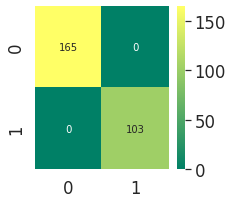

accuracy: 1.0000, precision: 1.0000, recall: 1.0000, F1: 1.0000, ROC_AUC:1.0000
<< model : Naive Bayes >>
confusion matrix


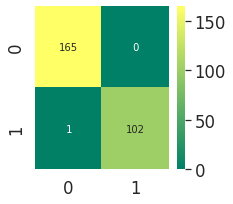

accuracy: 0.9963, precision: 1.0000, recall: 0.9903, F1: 0.9951, ROC_AUC:0.9951
<< model : KNN >>
confusion matrix


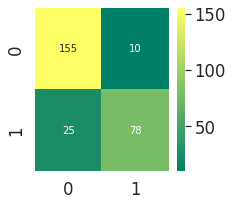

accuracy: 0.8694, precision: 0.8864, recall: 0.7573, F1: 0.8168, ROC_AUC:0.9596
<< model : linear Svm >>
confusion matrix


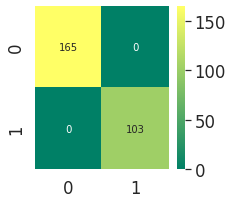

accuracy: 1.0000, precision: 1.0000, recall: 1.0000, F1: 1.0000, ROC_AUC:1.0000
<< model : Radial Svm >>
confusion matrix


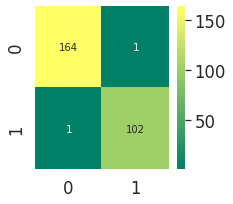

accuracy: 0.9925, precision: 0.9903, recall: 0.9903, F1: 0.9903, ROC_AUC:0.9986
<< model : Decision Tree >>
confusion matrix


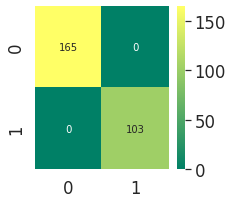

accuracy: 1.0000, precision: 1.0000, recall: 1.0000, F1: 1.0000, ROC_AUC:1.0000
<< model : RandomForest >>
confusion matrix


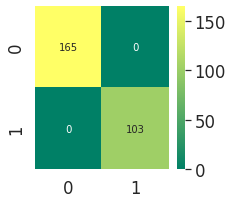

accuracy: 1.0000, precision: 1.0000, recall: 1.0000, F1: 1.0000, ROC_AUC:1.0000
<< model : AdaBoost >>
confusion matrix


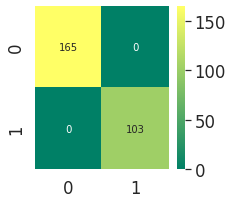

accuracy: 1.0000, precision: 1.0000, recall: 1.0000, F1: 1.0000, ROC_AUC:1.0000
<< model : XGBoost >>
confusion matrix


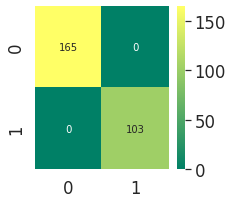

accuracy: 1.0000, precision: 1.0000, recall: 1.0000, F1: 1.0000, ROC_AUC:1.0000
<< model : LightBoost >>
confusion matrix


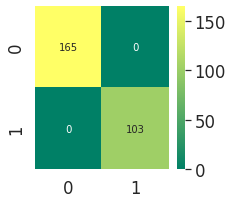

accuracy: 1.0000, precision: 1.0000, recall: 1.0000, F1: 1.0000, ROC_AUC:1.0000


,accuracy,precision,recall,f1,roc_auc
Logistic Regression,1.000000,1.000000,1.000000,1.000000,1.000000
Naive Bayes,0.996269,1.000000,0.990291,0.995122,0.995146
KNN,0.869403,0.886364,0.757282,0.816754,0.959576
linear Svm,1.000000,1.000000,1.000000,1.000000,1.000000
Radial Svm,0.992537,0.990291,0.990291,0.990291,0.998647
Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000
RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000
AdaBoost,1.000000,1.000000,1.000000,1.000000,1.000000
XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000
LightBoost,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
models = [LogisticRegression(), GaussianNB(), KNeighborsClassifier(n_neighbors=9),
          SVC(kernel='linear', probability=True), SVC(kernel='rbf', probability=True),
          DecisionTreeClassifier(), RandomForestClassifier(n_estimators=100), 
          AdaBoostClassifier(), XGBClassifier(), LGBMClassifier()]

classifiers=['Logistic Regression', 'Naive Bayes', 'KNN',
             'linear Svm', 'Radial Svm',
             'Decision Tree', 'RandomForest',
             'AdaBoost', 'XGBoost', 'LightBoost']

accuracy = []
precision = []
recall = []
f1 = []
roc_auc = []

for i in range(len(models)) :
  model = models[i]
  print('='*50)
  print('<< model :', classifiers[i],'>>')

  model.fit(X_train, y_train)
  pred = model.predict(X_valid)
  pred_proba = model.predict_proba(X_valid)[:, 1]

  get_clf_eval(y_valid, pred=pred, pred_proba=pred_proba)
  
  accuracy.append(accuracy_score(y_valid , pred))
  precision.append(precision_score(y_valid , pred))
  recall.append(recall_score(y_valid , pred))
  f1.append(f1_score(y_valid,pred))
  roc_auc.append(roc_auc_score(y_valid, pred_proba))

models_dataframe = pd.DataFrame({'accuracy':accuracy, 'precision':precision, 'recall':recall, 'f1':f1, 'roc_auc':roc_auc}, index=classifiers)
models_dataframe

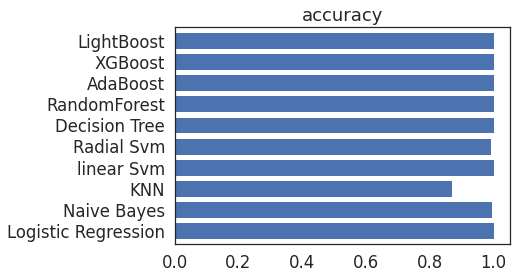

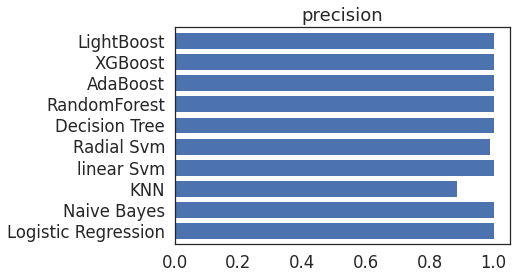

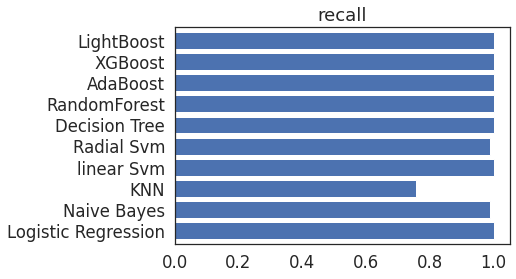

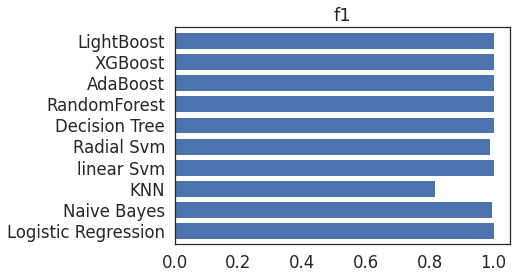

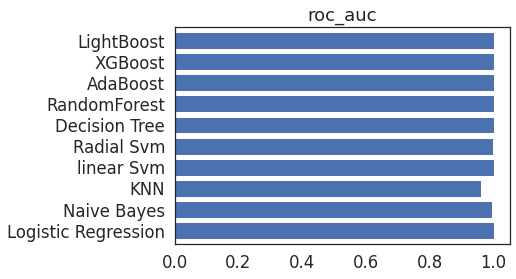

In [ ]:
for i in models_dataframe.columns :
  models_dataframe[i].plot.barh(width=0.8)
  plt.title(i)
  plt.show()

## 4-3) Hyper-Parameters Tuning
- GridSearchCV, RandomizedSearchCV

### Important Features Extraction

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

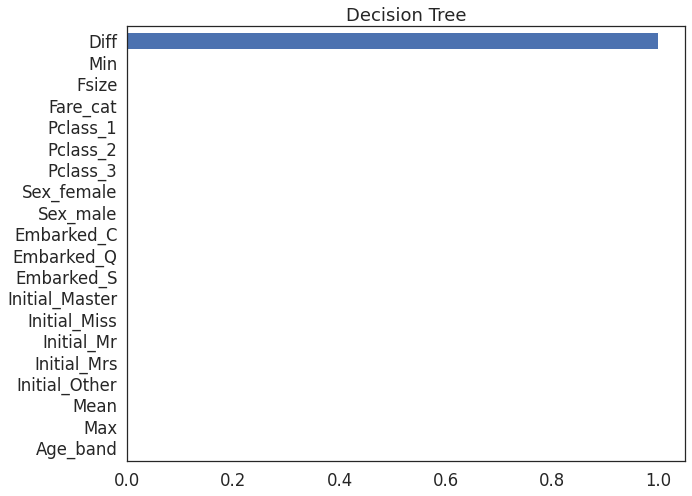

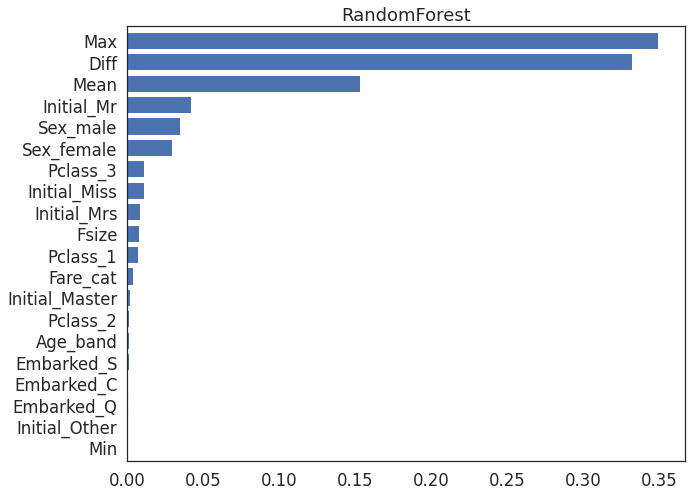

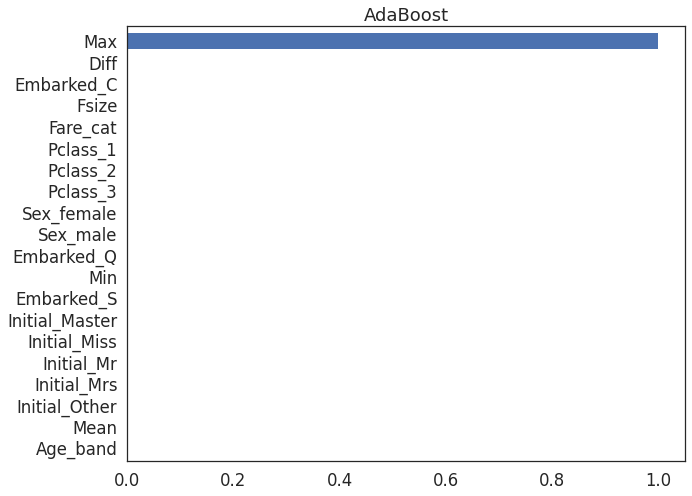

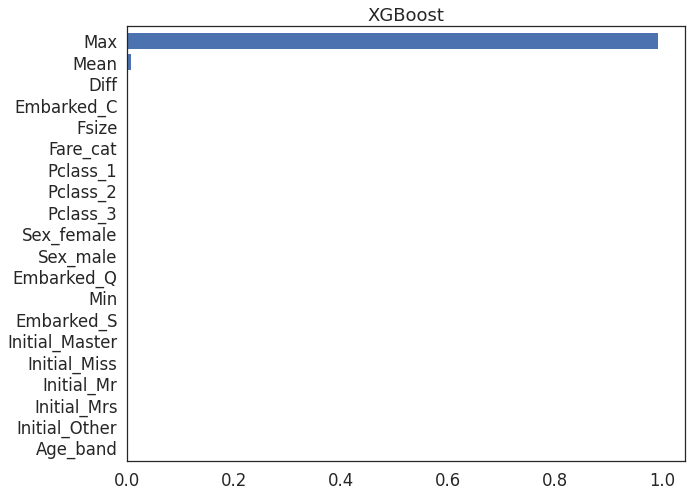

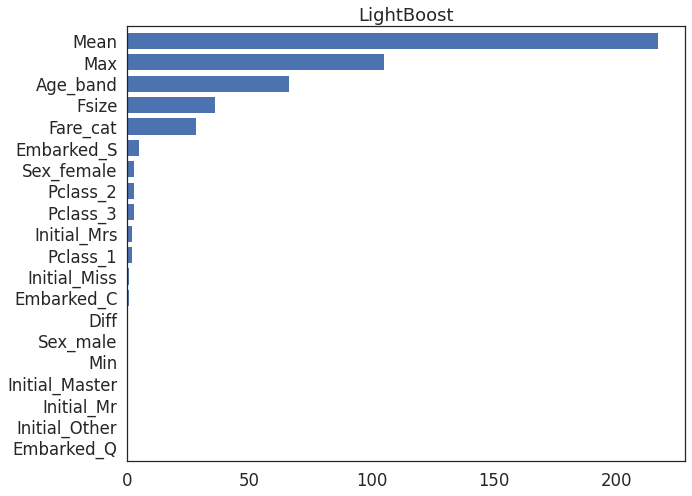

In [ ]:
for i in range(len(models)) :
  model = models[i]

  model.fit(X_train, y_train)

  try: 
    plt.figure(figsize=(10, 8))
    pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=True).plot.barh(width=0.8)
    plt.title(classifiers[i])
    plt.show()
  except :
    pass

## 4-4) Ensembling

- Voting, Bagging, Boosting, Stacking

### Voting

In [ ]:
voting_model = VotingClassifier(estimators=[('LR',LogisticRegression()),
                                            ('NB',GaussianNB()),
                                            ('KNN',KNeighborsClassifier(n_neighbors=9)),
                                            ('svm',SVC(kernel='linear', probability=True)),
                                            ('RBF',SVC(kernel='rbf', C=0.5, gamma=0.1, probability=True)),
                                            ('RF',RandomForestClassifier(n_estimators=100)),
                                            ('DT',DecisionTreeClassifier()),
                                            ('AdaBst',AdaBoostClassifier()),
                                            ('xgb',XGBClassifier()),
                                            ('lgb',LGBMClassifier())], 
                                voting='soft').fit(X_train, y_train)

confusion matrix


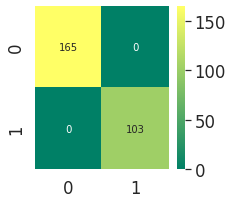

accuracy: 1.0000, precision: 1.0000, recall: 1.0000, F1: 1.0000, ROC_AUC:1.0000


In [ ]:
pred = voting_model.predict(X_valid)
pred_proba = voting_model.predict_proba(X_valid)[:, 1]
get_clf_eval(y_valid, pred=pred, pred_proba=pred_proba)

# 5) Prediction on Test Set & Submission

In [ ]:
test_Survived = pd.Series(voting_model.predict(test), name="Survived")

results = pd.concat([IDtest, test_Survived], axis=1)
results = results.astype('int')

results.to_csv("Titanic_sam_final.csv", index=False)

## 0.62200